# KNN Graph & Louvain Clustering with Neo4j GDS

This notebook demonstrates how to use the Neo4j Graph Data Science (GDS) Library to:
- Build a k-Nearest Neighbors (KNN) graph based on `chunkEmbedding` vectors
- Cluster the graph using the Louvain algorithm
- Inspect and visualize the resulting communities

---

## 1. Setup and Imports
Ensure your `.env` file is configured with NEO4J_URI, NEO4J_USERNAME, and NEO4J_PASSWORD.

In [27]:
import os
import pandas as pd
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
import matplotlib.pyplot as plt

load_dotenv()
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
print(NEO4J_URI)
gds = GraphDataScience(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD), aura_ds=True)
print('Neo4j GDS Version:', gds.version())

neo4j+s://97c64e0e.databases.neo4j.io
Neo4j GDS Version: 2.18.0


In [28]:
from neo4j import GraphDatabase
import pandas as pd


driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

query = """
MATCH (c:Conversation)-[:FIRST]->(start:Message)
MATCH path = (start)-[:NEXT*0..]->(m:Message)
WITH c, m
ORDER BY c.id, m.postTime

MATCH (m)-[:HAS_CONTEXT]->(doc:Document)
WITH c.id AS conversationId, m.postTime AS time, doc.index AS cluster
ORDER BY conversationId, time

WITH conversationId, collect(cluster) AS clusterSeq

UNWIND range(0, size(clusterSeq)-2) AS i
WITH clusterSeq[i] AS fromCluster, clusterSeq[i+1] AS toCluster
RETURN fromCluster, toCluster, count(*) AS flow
ORDER BY flow DESC
"""

with driver.session() as session:
    result = session.run(query)
    records = [record.data() for record in result]

df = pd.DataFrame(records)
print(df.head())


  fromCluster toCluster  flow
0        7138     13623     5
1        4959      9627     4
2        5476      6732     4
3        9778      9703     4
4        9617      9597     3


In [3]:
import pandas as pd
import plotly.graph_objects as go

# Assuming df is your DataFrame with 'fromCluster', 'toCluster', and 'flow' columns

# Get unique clusters
all_clusters = pd.unique(df[['fromCluster', 'toCluster']].values.ravel())
cluster_to_id = {cluster: idx for idx, cluster in enumerate(all_clusters)}

# Create Sankey nodes
nodes = dict(label=[str(cluster) for cluster in all_clusters])

# Create Sankey links
links = dict(
    source=df['fromCluster'].map(cluster_to_id).tolist(),
    target=df['toCluster'].map(cluster_to_id).tolist(),
    value=df['flow'].tolist()
)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=nodes,
    link=links
)])

fig.update_layout(
    title_text="Conversation Cluster Flow Sankey",
    font_size=10
)

fig.show()


C:\Users\Alison Cossette\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
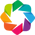

:Chord   [start,end]

In [4]:
import pandas as pd
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Suppose df is your transitions DataFrame:
# df = pd.DataFrame({
#   'fromCluster': [...],
#   'toCluster': [...],
#   'flow': [...]
# })

# Chord expects tuples (source, target, value)
links = [(row['fromCluster'], row['toCluster'], row['flow']) for _, row in df.iterrows()]

# Create Chord diagram
chord = hv.Chord(links)

# Customize the look
chord.opts(
    opts.Chord(
        cmap='Category20',
        edge_color='source',
        node_color='index',
        labels='index',
        width=600,
        height=600,
        title="Conversation Cluster Flows (Chord Diagram)"
    )
)

# Show it
hv.save(chord, 'conversation_cluster_flows.html')
chord


In [6]:
# Keep only top-N edges
N = 50
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
top_edges = sorted_edges[:N]

# Create a new graph
G_top = nx.DiGraph()
G_top.add_edges_from([(u, v, d) for u, v, d in top_edges])

# Positions and degrees
pos_top = nx.circular_layout(G_top)
node_degree = dict(G_top.degree())
edge_weights = [d['weight'] for _, _, d in top_edges]

# Edge traces
edge_traces = []
for u, v, d in G_top.edges(data=True):
    x0, y0 = pos_top[u]
    x1, y1 = pos_top[v]
    width = 0.5 + 4 * (d['weight'] / max(edge_weights))
    edge_traces.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(width=width, color='rgba(150,150,150,0.4)'),
        hoverinfo='none'
    ))

# Node trace with minimal text
node_x = []
node_y = []
node_text = []
for node in G_top.nodes():
    x, y = pos_top[node]
    node_x.append(x)
    node_y.append(y)
    # Only show label if degree > 2
    node_text.append(str(node) if node_degree[node] > 2 else "")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="bottom center",
    marker=dict(
        size=[5 + 3 * node_degree[n] for n in G_top.nodes()],
        color=list(node_degree.values()),
        colorscale='Viridis',
        line=None
    ),
    hoverinfo='text'
)

# Plot
fig = go.Figure(data=edge_traces + [node_trace],
                 layout=go.Layout(
                     title="Top 100 Conversation Cluster Flows",
                     width=800, height=800,
                     showlegend=False,
                     hovermode='closest',
                     margin=dict(b=20, l=5, r=5, t=40),
                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
)
fig.show()


NameError: name 'G' is not defined

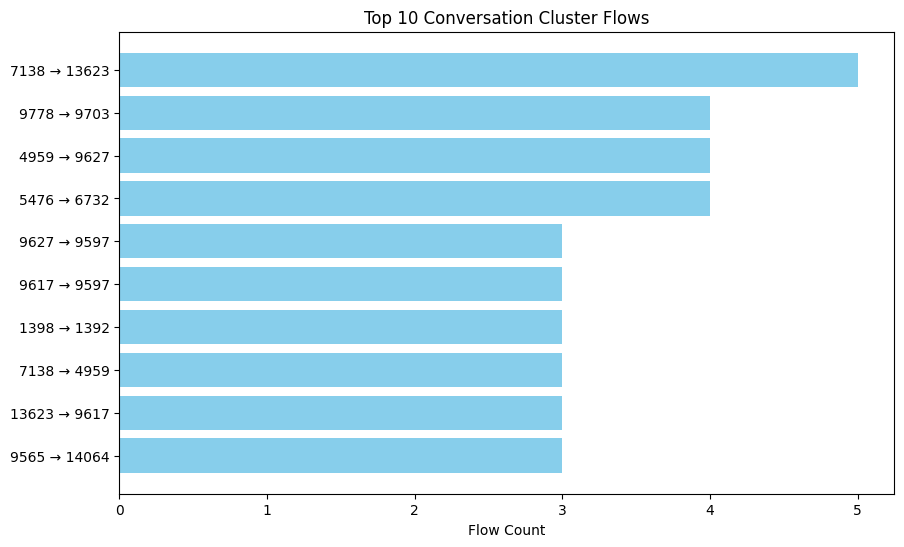

In [7]:
# Top 10 flows
top_flows = df.sort_values('flow', ascending=False).head(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(
    [f"{f} → {t}" for f, t in zip(top_flows['fromCluster'], top_flows['toCluster'])],
    top_flows['flow'],
    color='skyblue'
)
plt.xlabel("Flow Count")
plt.title("Top 10 Conversation Cluster Flows")
plt.gca().invert_yaxis()
plt.show()


In [14]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Alison Cossette\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import seaborn as sns

pivot = df.pivot_table(index='fromCluster', columns='toCluster', values='flow', fill_value=0)
plt.figure(figsize=(12,10))
sns.heatmap(pivot, cmap='viridis', linewidths=0.1)
plt.title("Conversation Cluster Transition Matrix")
plt.xlabel("To Cluster")
plt.ylabel("From Cluster")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

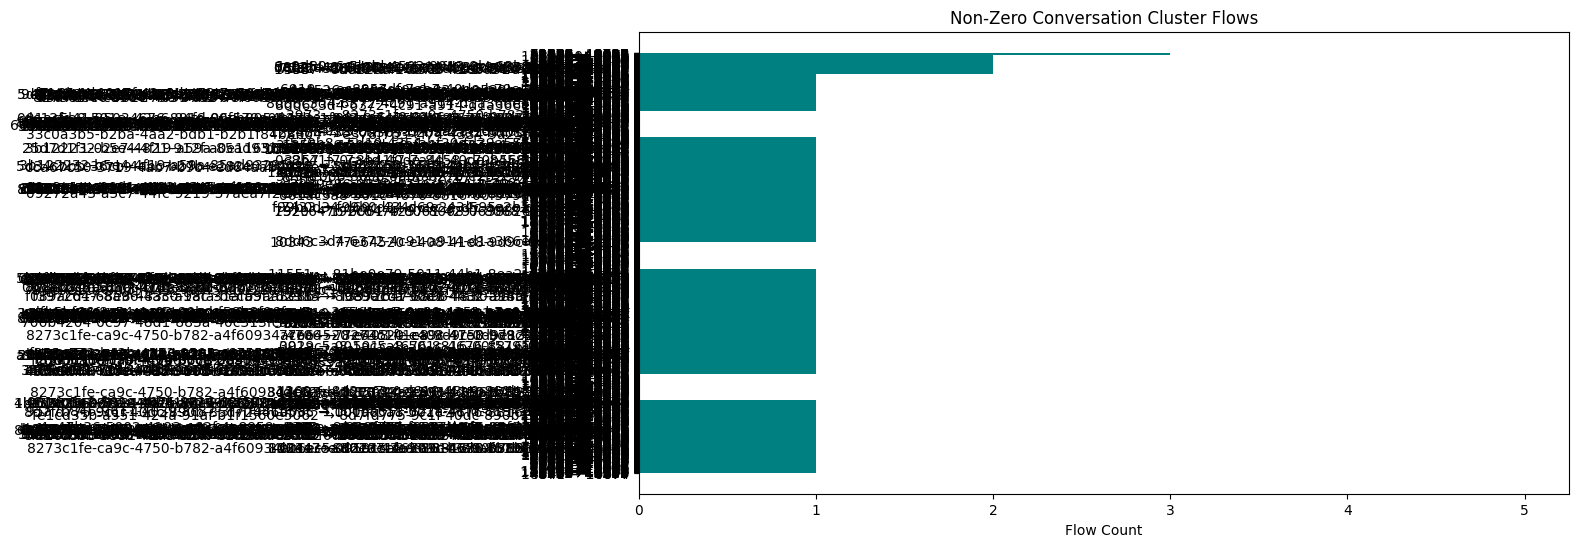

In [9]:
# Filter to non-zero flows
active_flows = df[df['flow'] > 0].copy()

# Sort by biggest flows
active_flows = active_flows.sort_values('flow', ascending=False)

# Bar chart for top transitions
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(
    [f"{f} → {t}" for f, t in zip(active_flows['fromCluster'], active_flows['toCluster'])],
    active_flows['flow'],
    color='teal'
)
plt.xlabel("Flow Count")
plt.title("Non-Zero Conversation Cluster Flows")
plt.gca().invert_yaxis()
plt.show()


In [10]:
import plotly.graph_objects as go

# For illustration: Suppose these are your top paths
# Usually you'd build these from your df
labels = ["Start", "Cluster A", "Cluster B", "Cluster C", "End"]
sources = [0, 1, 2, 3]
targets = [1, 2, 3, 4]
values = [100, 80, 60, 40]  # volume of users/messages

# Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(title_text="Conversation Flow (Mixpanel-style)", font_size=10)
fig.show()


C:\Users\Alison Cossette\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [11]:
df

fromCluster toCluster  flow
0           7138     13623     5
1           4959      9627     4
2           5476      6732     4
3           9778      9703     4
4           9617      9597     3
...          ...       ...   ...
2932        7960      6044     1
2933        6044      3319     1
2934        3319     14078     1
2935       14078     14071     1
2936       14071     14074     1

[2937 rows x 3 columns]

In [12]:
from IPython.display import display, HTML

html_code = """
<div id="viz"></div>
<script src="https://d3js.org/d3.v7.min.js"></script>
<script>
// Data for demonstration (replace with your real data!)
const firstDensity = [
  { cluster: "1876", count: 40 },
  { cluster: "9620", count: 30 },
  { cluster: "7138", count: 20 },
  { cluster: "9778", count: 10 }
];

const secondDensity = [
  { cluster: "1876", count: 25 },
  { cluster: "9620", count: 35 },
  { cluster: "7138", count: 15 },
  { cluster: "9778", count: 20 }
];

// Cluster positions (fixed layout - adjust for your real clusters)
const clusterPositions = {
  "1876": { x: 200, y: 200 },
  "9620": { x: 400, y: 200 },
  "7138": { x: 300, y: 350 },
  "9778": { x: 500, y: 350 }
};

const width = 600, height = 400;
const svg = d3.select("#viz").append("svg")
  .attr("width", width)
  .attr("height", height);

// Scale for circle radius
const radiusScale = d3.scaleSqrt()
  .domain([0, d3.max(firstDensity.concat(secondDensity), d => d.count)])
  .range([5, 40]);

// Initial circles for first message densities
const circles = svg.selectAll("circle")
  .data(firstDensity, d => d.cluster)
  .enter()
  .append("circle")
  .attr("cx", d => clusterPositions[d.cluster].x)
  .attr("cy", d => clusterPositions[d.cluster].y)
  .attr("r", d => radiusScale(d.count))
  .attr("fill", "steelblue")
  .attr("opacity", 0.7);

// Labels
svg.selectAll("text")
  .data(firstDensity, d => d.cluster)
  .enter()
  .append("text")
  .attr("x", d => clusterPositions[d.cluster].x)
  .attr("y", d => clusterPositions[d.cluster].y + 5)
  .attr("text-anchor", "middle")
  .text(d => d.cluster)
  .style("font-size", "12px")
  .style("fill", "#333");

// Transition to second density after 2 seconds
setTimeout(() => {
  circles.data(secondDensity, d => d.cluster)
    .transition()
    .duration(1500)
    .attr("r", d => radiusScale(d.count))
    .attr("fill", "tomato");
}, 2000);

// Optional: show a label for stage
const stageLabel = svg.append("text")
  .attr("x", width / 2)
  .attr("y", 30)
  .attr("text-anchor", "middle")
  .style("font-size", "16px")
  .style("fill", "#555")
  .text("First Message Density");

setTimeout(() => {
  stageLabel.text("Second Message Density");
}, 2000);
</script>
"""

display(HTML(html_code))


In [16]:
from IPython.display import display, HTML

html_test = """
<div>Hello World from JavaScript!</div>
<script>
document.querySelector("div").style.color = "red";
</script>
"""

display(HTML(html_test))


In [18]:
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Cluster Density Animation with Slider</title>
  <script src="https://d3js.org/d3.v7.min.js"></script>
  <style>
    #controls {
      margin: 20px;
      text-align: center;
    }
  </style>
</head>
<body>
  <div id="viz"></div>
  <div id="controls">
    <input type="range" id="timeSlider" min="1" max="3" step="1" value="1">
    <label id="stageLabel">First Message Density</label>
    <button id="playButton">Play</button>
  </div>

  <script>
  // Example data for three stages
  const firstDensity = [
    { cluster: "1876", count: 40 },
    { cluster: "9620", count: 30 },
    { cluster: "7138", count: 20 },
    { cluster: "9778", count: 10 }
  ];

  const secondDensity = [
    { cluster: "1876", count: 25 },
    { cluster: "9620", count: 35 },
    { cluster: "7138", count: 15 },
    { cluster: "9778", count: 20 }
  ];

  const thirdDensity = [
    { cluster: "1876", count: 30 },
    { cluster: "9620", count: 20 },
    { cluster: "7138", count: 25 },
    { cluster: "9778", count: 15 }
  ];

  const clusterPositions = {
    "1876": { x: 150, y: 200 },
    "9620": { x: 300, y: 200 },
    "7138": { x: 450, y: 200 },
    "9778": { x: 600, y: 200 }
  };

  const width = 700, height = 400;
  const svg = d3.select("#viz").append("svg")
    .attr("width", width)
    .attr("height", height);

  const radiusScale = d3.scaleSqrt()
    .domain([0, d3.max(firstDensity.concat(secondDensity).concat(thirdDensity), d => d.count)])
    .range([10, 50]);

  const circles = svg.selectAll("circle")
    .data(firstDensity, d => d.cluster)
    .enter()
    .append("circle")
    .attr("cx", d => clusterPositions[d.cluster].x)
    .attr("cy", d => clusterPositions[d.cluster].y)
    .attr("r", d => radiusScale(d.count))
    .attr("fill", "steelblue")
    .attr("opacity", 0.7);

  svg.selectAll("text.cluster")
    .data(firstDensity, d => d.cluster)
    .enter()
    .append("text")
    .attr("class", "cluster")
    .attr("x", d => clusterPositions[d.cluster].x)
    .attr("y", d => clusterPositions[d.cluster].y + 5)
    .attr("text-anchor", "middle")
    .text(d => d.cluster)
    .style("font-size", "14px")
    .style("fill", "#333");

  const stageLabel = d3.select("#stageLabel");

  // Function to update based on stage
  function updateStage(stage) {
    let data, color, label;
    if (stage == 1) {
      data = firstDensity;
      color = "steelblue";
      label = "First Message Density";
    } else if (stage == 2) {
      data = secondDensity;
      color = "tomato";
      label = "Second Message Density";
    } else {
      data = thirdDensity;
      color = "green";
      label = "Third Message Density";
    }

    circles.data(data, d => d.cluster)
      .transition()
      .duration(1000)
      .attr("r", d => radiusScale(d.count))
      .attr("fill", color);

    stageLabel.text(label);
  }

  // Slider interaction
  document.getElementById("timeSlider").addEventListener("input", function() {
    const stage = +this.value;
    updateStage(stage);
  });

  // Play button interaction
  let currentStage = 1;
  let playing = false;
  let interval;

  document.getElementById("playButton").addEventListener("click", function() {
    if (!playing) {
      playing = true;
      this.textContent = "Pause";
      interval = setInterval(() => {
        currentStage = (currentStage % 3) + 1;
        document.getElementById("timeSlider").value = currentStage;
        updateStage(currentStage);
      }, 2000);
    } else {
      playing = false;
      this.textContent = "Play";
      clearInterval(interval);
    }
  });
  </script>
</body>
</html>


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

In [20]:
from IPython.display import IFrame
IFrame("graph_dynamic_edges.html", width=900, height=600)

In [22]:
import json

In [23]:

# Cypher query to get the triples
query = """
MATCH (c:Conversation)-[:FIRST]->(start:Message)
MATCH path = (start)-[:NEXT*0..5]->(m:Message)
WHERE (m)-[:HAS_CONTEXT]->(:Document)
WITH c, path, [n IN nodes(path) WHERE (n)-[:HAS_CONTEXT]->(:Document)] AS responses
WITH c, responses[0] AS firstResponse, responses[1] AS secondResponse, responses[2] AS thirdResponse
WHERE secondResponse IS NOT NULL AND thirdResponse IS NOT NULL
MATCH (firstResponse)-[:HAS_CONTEXT]->(d1:Document)
MATCH (secondResponse)-[:HAS_CONTEXT]->(d2:Document)
MATCH (thirdResponse)-[:HAS_CONTEXT]->(d3:Document)
RETURN d1.community AS firstCluster, d2.community AS secondCluster, d3.community AS thirdCluster, count(*) AS count
ORDER BY count DESC
"""

# Fetch data from Neo4j
with driver.session() as session:
    result = session.run(query)
    data = [record.data() for record in result]

driver.close()

# Build nested JSON
root = {"name": "root", "children": []}

for row in data:
    first = str(row['firstCluster'])
    second = str(row['secondCluster'])
    third = str(row['thirdCluster'])
    count = int(row['count'])

    # Find or create the first-level cluster
    first_node = next((item for item in root['children'] if item['name'] == first), None)
    if not first_node:
        first_node = {"name": first, "children": []}
        root['children'].append(first_node)

    # Find or create the second-level cluster
    second_node = next((item for item in first_node['children'] if item['name'] == second), None)
    if not second_node:
        second_node = {"name": second, "children": []}
        first_node['children'].append(second_node)

    # Add the third-level cluster as leaf node
    second_node['children'].append({
        "name": third,
        "value": count
    })

# Save to JSON file
with open("sunburst_data.json", "w") as f:
    json.dump(root, f, indent=2)

print("✅ Sunburst data written to sunburst_data.json")

C:\Users\Alison Cossette\AppData\Local\Temp\ipykernel_3952\551129413.py:17: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



✅ Sunburst data written to sunburst_data.json


In [24]:

# Cypher query
query = """
MATCH (c:Conversation)-[:FIRST]->(start:Message)
MATCH path = (start)-[:NEXT*0..5]->(m:Message)
WHERE (m)-[:HAS_CONTEXT]->(:Document)
WITH c, path, [n IN nodes(path) WHERE (n)-[:HAS_CONTEXT]->(:Document)] AS responses
WITH c, responses[0] AS firstResponse, responses[1] AS secondResponse, responses[2] AS thirdResponse
WHERE secondResponse IS NOT NULL AND thirdResponse IS NOT NULL
MATCH (firstResponse)-[:HAS_CONTEXT]->(d1:Document)
MATCH (secondResponse)-[:HAS_CONTEXT]->(d2:Document)
MATCH (thirdResponse)-[:HAS_CONTEXT]->(d3:Document)
RETURN d1.community AS firstCluster, d2.community AS secondCluster, d3.community AS thirdCluster, count(*) AS count
ORDER BY count DESC
"""

with driver.session() as session:
    result = session.run(query)
    data = [record.data() for record in result]

driver.close()

# Build nested JSON
root = {"name": "root", "children": []}

for row in data:
    first = str(row['firstCluster'])
    second = str(row['secondCluster'])
    third = str(row['thirdCluster'])
    count = int(row['count'])

    first_node = next((item for item in root['children'] if item['name'] == first), None)
    if not first_node:
        first_node = {"name": first, "children": []}
        root['children'].append(first_node)

    second_node = next((item for item in first_node['children'] if item['name'] == second), None)
    if not second_node:
        second_node = {"name": second, "children": []}
        first_node['children'].append(second_node)

    second_node['children'].append({
        "name": third,
        "value": count
    })

# Save JSON data
with open("sunburst_data.json", "w") as f:
    json.dump(root, f, indent=2)

print("✅ sunburst_data.json written!")

# Generate Sunburst HTML
html_content = """
<!DOCTYPE html>
<meta charset="utf-8">
<title>Sunburst of Cluster Transitions</title>
<script src="https://d3js.org/d3.v7.min.js"></script>
<body>
<div id="chart"></div>
<script>
d3.json("sunburst_data.json").then(data => {
  const width = 700;
  const radius = width / 2;

  const partition = data => {
    const root = d3.hierarchy(data)
      .sum(d => d.value || 0)
      .sort((a, b) => b.value - a.value);
    return d3.partition()
      .size([2 * Math.PI, radius])(root);
  };

  const rootNode = partition(data);

  const arc = d3.arc()
    .startAngle(d => d.x0)
    .endAngle(d => d.x1)
    .innerRadius(d => d.y0)
    .outerRadius(d => d.y1);

  const svg = d3.select("#chart").append("svg")
    .attr("width", width)
    .attr("height", width)
    .append("g")
    .attr("transform", `translate(${width / 2},${width / 2})`);

  svg.selectAll("path")
    .data(rootNode.descendants().filter(d => d.depth))
    .enter()
    .append("path")
    .attr("d", arc)
    .attr("fill", d => d3.interpolateRainbow(d.x0 / (2 * Math.PI)))
    .attr("stroke", "#fff")
    .append("title")
    .text(d => `${d.ancestors().map(d => d.data.name).reverse().join("/")}: ${d.value}`);
});
</script>
</body>
"""

with open("sunburst_triples.html", "w") as f:
    f.write(html_content)

print("✅ sunburst_triples.html created!")

# Display in notebook
from IPython.display import IFrame
IFrame("sunburst_triples.html", width=800, height=600)

C:\Users\Alison Cossette\AppData\Local\Temp\ipykernel_3952\1713070401.py:16: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



✅ sunburst_data.json written!
✅ sunburst_triples.html created!


In [25]:


query = """
MATCH (c:Conversation)-[:FIRST]->(start:Message)
MATCH path = (start)-[:NEXT*0..5]->(m:Message)
WHERE (m)-[:HAS_CONTEXT]->(:Document)
WITH c, path, [n IN nodes(path) WHERE (n)-[:HAS_CONTEXT]->(:Document)] AS responses
WITH c, responses[0] AS firstResponse, responses[1] AS secondResponse, responses[2] AS thirdResponse
WHERE secondResponse IS NOT NULL AND thirdResponse IS NOT NULL
MATCH (firstResponse)-[:HAS_CONTEXT]->(d1:Document)
MATCH (secondResponse)-[:HAS_CONTEXT]->(d2:Document)
MATCH (thirdResponse)-[:HAS_CONTEXT]->(d3:Document)
RETURN d1.community AS firstCluster, d2.community AS secondCluster, d3.community AS thirdCluster, count(*) AS count
ORDER BY count DESC
"""

with driver.session() as session:
    result = session.run(query)
    data = [record.data() for record in result]

driver.close()

# Build nested JSON
root = {"name": "root", "children": []}

for row in data:
    first = str(row['firstCluster'])
    second = str(row['secondCluster'])
    third = str(row['thirdCluster'])
    count = int(row['count'])

    first_node = next((item for item in root['children'] if item['name'] == first), None)
    if not first_node:
        first_node = {"name": first, "children": []}
        root['children'].append(first_node)

    second_node = next((item for item in first_node['children'] if item['name'] == second), None)
    if not second_node:
        second_node = {"name": second, "children": []}
        first_node['children'].append(second_node)

    second_node['children'].append({
        "name": third,
        "value": count
    })

# Save to JSON for later use (optional)
with open("sunburst_data.json", "w") as f:
    json.dump(root, f, indent=2)

print("✅ sunburst_data.json created")

# Embed the JSON data directly into the HTML
html_content = f"""
<!DOCTYPE html>
<meta charset="utf-8">
<title>Sunburst of Cluster Transitions</title>
<script src="https://d3js.org/d3.v7.min.js"></script>
<body>
<div id="chart"></div>
<script>
const data = {json.dumps(root)};

const width = 700;
const radius = width / 2;

const partition = data => {{
  const root = d3.hierarchy(data)
    .sum(d => d.value || 0)
    .sort((a, b) => b.value - a.value);
  return d3.partition()
    .size([2 * Math.PI, radius])(root);
}};

const rootNode = partition(data);

const arc = d3.arc()
  .startAngle(d => d.x0)
  .endAngle(d => d.x1)
  .innerRadius(d => d.y0)
  .outerRadius(d => d.y1);

const svg = d3.select("#chart").append("svg")
  .attr("width", width)
  .attr("height", width)
  .append("g")
  .attr("transform", `translate(${{width / 2}},${{width / 2}})`);

svg.selectAll("path")
  .data(rootNode.descendants().filter(d => d.depth))
  .enter()
  .append("path")
  .attr("d", arc)
  .attr("fill", d => d3.interpolateRainbow(d.x0 / (2 * Math.PI)))
  .attr("stroke", "#fff")
  .append("title")
  .text(d => `${{d.ancestors().map(d => d.data.name).reverse().join("/")}}: ${{d.value}}`);
</script>
</body>
"""

with open("sunburst_triples.html", "w") as f:
    f.write(html_content)

print("✅ sunburst_triples.html created with embedded data!")

from IPython.display import IFrame
IFrame("sunburst_triples.html", width=800, height=600)


C:\Users\Alison Cossette\AppData\Local\Temp\ipykernel_3952\1852704906.py:15: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



✅ sunburst_data.json created
✅ sunburst_triples.html created with embedded data!


In [32]:

query = """
MATCH (c:Conversation)-[:FIRST]->(start:Message)
MATCH path = (start)-[:NEXT*0..5]->(m:Message)
WHERE (m)-[:HAS_CONTEXT]->(:Document)
WITH c, path, [n IN nodes(path) WHERE (n)-[:HAS_CONTEXT]->(:Document)] AS responses
WITH c, responses[0] AS firstResponse, responses[1] AS secondResponse, responses[2] AS thirdResponse
WHERE secondResponse IS NOT NULL AND thirdResponse IS NOT NULL
MATCH (firstResponse)-[:HAS_CONTEXT]->(d1:Document)
MATCH (secondResponse)-[:HAS_CONTEXT]->(d2:Document)
MATCH (thirdResponse)-[:HAS_CONTEXT]->(d3:Document)
RETURN d1.community AS firstCluster, d2.community AS secondCluster, d3.community AS thirdCluster, count(*) AS count
ORDER BY count DESC
"""

with driver.session() as session:
    result = session.run(query)
    data = [record.data() for record in result]

driver.close()

# Build unique nodes
nodes_set = set()
links = []

for row in data:
    first = str(row['firstCluster'])
    second = str(row['secondCluster'])
    third = str(row['thirdCluster'])
    count = int(row['count'])
    
    # Record nodes
    nodes_set.update([first, second, third])
    
    # First to second link
    links.append({
        "source": first,
        "target": second,
        "value": count
    })
    
    # Second to third link
    links.append({
        "source": second,
        "target": third,
        "value": count
    })

# Build final data
nodes = [{"name": n} for n in nodes_set]
sankey_data = {"nodes": nodes, "links": links}

# Write JSON (optional)
with open("sankey_data.json", "w") as f:
    json.dump(sankey_data, f, indent=2)

print("✅ sankey_data.json created!")

# Create the HTML content with fixed JS template literals (double braces!)
html_content = f"""
<!DOCTYPE html>
<meta charset="utf-8">
<title>Interactive Cluster Transition Sankey</title>
<script src="https://d3js.org/d3.v7.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/d3-sankey@0.12.3/dist/d3-sankey.min.js"></script>
<style>
  .tooltip {{
    position: absolute;
    text-align: center;
    padding: 6px;
    font: 12px sans-serif;
    background: lightsteelblue;
    border: 1px solid #aaa;
    border-radius: 4px;
    pointer-events: none;
  }}
</style>
<body>
<svg width="960" height="700"></svg>
<script>
const data = {json.dumps(sankey_data)};

const svg = d3.select("svg"),
      width = +svg.attr("width"),
      height = +svg.attr("height");

const sankey = d3.sankey()
    .nodeWidth(15)
    .nodePadding(10)
    .extent([[1, 1], [width - 1, height - 6]]);

const {nodes, links} = sankey({{
  nodes: data.nodes.map(d => Object.assign({{}}, d)),
  links: data.links.map(d => Object.assign({{}}, d))
}});

const tooltip = d3.select("body").append("div")
  .attr("class", "tooltip")
  .style("opacity", 0);

svg.append("g")
  .selectAll("rect")
  .data(nodes)
  .join("rect")
    .attr("x", d => d.x0)
    .attr("y", d => d.y0)
    .attr("height", d => d.y1 - d.y0)
    .attr("width", d => d.x1 - d.x0)
    .attr("fill", "#69b3a2")
    .on("mouseover", (event, d) => {{
      tooltip.transition().duration(200).style("opacity", .9);
      tooltip.html(`Node: ${{d.name}}<br>Value: ${{d.value}}`)
        .style("left", (event.pageX + 10) + "px")
        .style("top", (event.pageY - 28) + "px");
    }})
    .on("mouseout", () => {{
      tooltip.transition().duration(500).style("opacity", 0);
    }})
  .append("title")
    .text(d => `Node: ${{d.name}}\\nTotal: ${{d.value}}`);

svg.append("g")
  .attr("fill", "none")
  .attr("stroke-opacity", 0.5)
  .selectAll("g")
  .data(links)
  .join("path")
    .attr("d", d3.sankeyLinkHorizontal())
    .attr("stroke", "#000")
    .attr("stroke-width", d => Math.max(1, d.width))
    .on("mouseover", (event, d) => {{
      tooltip.transition().duration(200).style("opacity", .9);
      tooltip.html(`Flow: ${{d.source.name}} → ${{d.target.name}}<br>Value: ${{d.value}}`)
        .style("left", (event.pageX + 10) + "px")
        .style("top", (event.pageY - 28) + "px");
    }})
    .on("mouseout", () => {{
      tooltip.transition().duration(500).style("opacity", 0);
    }})
  .append("title")
    .text(d => `${{d.source.name}} → ${{d.target.name}}\\nValue: ${{d.value}}`);

svg.append("g")
  .style("font", "10px sans-serif")
  .selectAll("text")
  .data(nodes)
  .join("text")
    .attr("x", d => d.x0 < width / 2 ? d.x1 + 6 : d.x0 - 6)
    .attr("y", d => (d.y1 + d.y0) / 2)
    .attr("dy", "0.35em")
    .attr("text-anchor", d => d.x0 < width / 2 ? "start" : "end")
    .text(d => d.name);

</script>
</body>
"""

# Write HTML file with UTF-8 encoding
with open("sankey_transitions.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print("✅ sankey_transitions.html created with interactive Sankey diagram and tooltips!")

from IPython.display import IFrame
IFrame("sankey_transitions.html", width=1000, height=750)

C:\Users\Alison Cossette\AppData\Local\Temp\ipykernel_3952\2385080072.py:15: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



✅ sankey_data.json created!
✅ sankey_transitions.html created with interactive Sankey diagram and tooltips!
